In [1]:
%%capture
import operator

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from matplotlib import pyplot as plt
from tensorflow.keras import layers, utils, losses, models as mds, optimizers

if imp.util.find_spec('aggdraw'): import aggdraw
if imp.util.find_spec('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers
if imp.util.find_spec('tensorflow_models'): from official.vision.beta.ops import augment as visaugment
if imp.util.find_spec('tensorflow_probability'): from tensorflow_probability import distributions as tfd
if imp.util.find_spec('keras_tuner'): import keras_tuner as kt

2022-04-01 11:01:00.835726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 11:01:00.836054: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMG_SIZE = 264
N_CLASSES = 102

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_0 (Sequential)      (None, 65, 65, 32)   1024        ['input_3[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_8 (Conv2D)            (None, 131, 131, 32  896         []                               |
|                              )                                                                 |
|                                                                                           

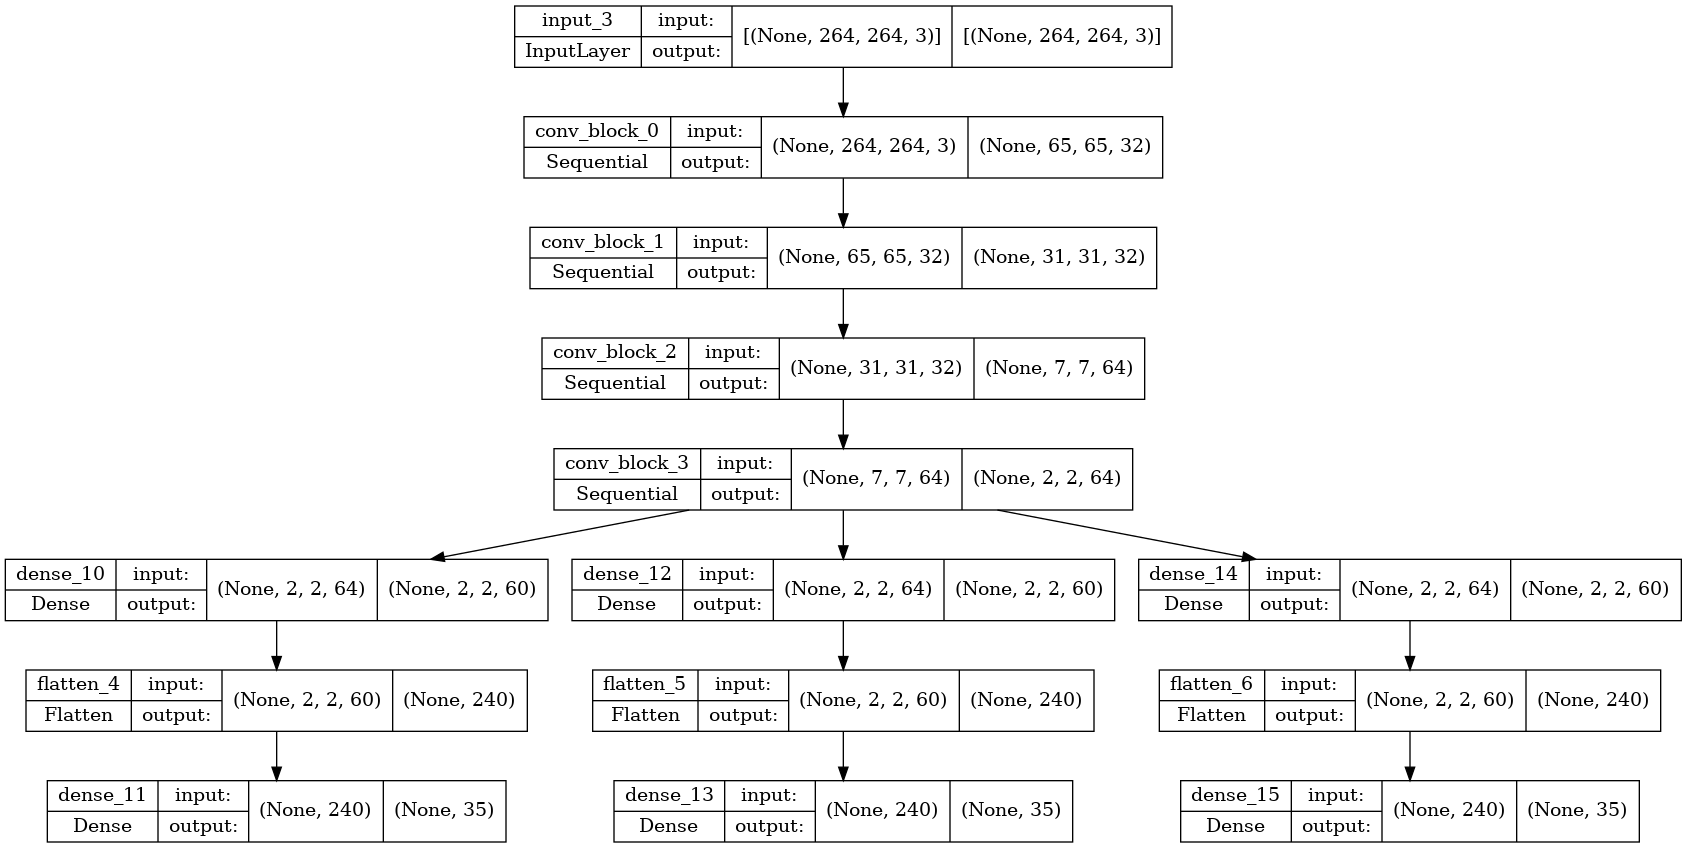

In [5]:
class SplitSparseCategoricalCrossentropy(losses.SparseCategoricalCrossentropy):
    def __init__(self, from_logits=False, **kwargs):
        super().__init__(from_logits, **kwargs)

    def call(self, y_true, y_pred):
        scale = tf.squeeze(tf.where(tf.equal(y_true, 0), .5, 1))
        base = super().call(y_true, y_pred)
        return tf.math.multiply(base, scale)

conv_id = -1

def increment_conv_id():
    global conv_id
    conv_id += 1

    return conv_id

def conv_block(filters, strides=1, dr=None, **kwargs):
    ls = [
        layers.Conv2D(filters, 3, strides=strides, **kwargs),
        # SEBlock(filters),
        layers.MaxPool2D(2),
        # layers.MaxPool2D(strides) if strides > 1 else None,
        # layers.SpatialDropout2D(dr) if dr is not None else None,
        layers.BatchNormalization()
    ]
    ls = list(filter(lambda x: x is not None, ls))

    return tf.keras.Sequential(ls, name='conv_block_' + str(increment_conv_id()))

def attentive_merge(q, v):
    v = layers.Dense(q.shape[-1])(v) if v.shape[-1] != q.shape[-1] else v
    return layers.Attention()([q, v])

def multi_level_merge(q, vs):
    format = lambda t: layers.Reshape([-1, t.shape[-1]])(t)
    unformat = lambda t,s: layers.Reshape(s[1:])(t)

    output = reduce(lambda y,x: attentive_merge(y, format(x)), vs, format(q))

    v = unformat(output, q.shape)
    return v

class Fibo(object):
    def __init__(self, first, second, limit=None):
        self.first = first
        self.second = second
        self.limit = limit
    
    def next(self):
        v = self.first + self.second
        limit_cond = self.limit and v < self.limit
        self.first, self.second = (self.second, v) if limit_cond else (self.second, self.limit)
        return self.second
    
    def get(self):
        return self.second

"""
Heat indicates a conv down operation. Chill follows heat convs to preserve the spatial dimensions.
Reheat is a conv up operation which follows chill convs.
"""
def assemble_backbone(input_tensor, depth, skip_rates, skip_start_depth,
    heat=1, chill=1, reheat=8,
    min_channels=32, max_channels=1024
):
    channel_fibo = Fibo(0, min_channels, max_channels)
    channel_fn = lambda: min(channel_fibo.next(), max_channels)
    conf_fn = lambda x: (2, channel_fn()) if x%(heat+chill) == 0 else (1, channel_fibo.get())
    dropout_fn = lambda x: .05*x*(1/log(x, max_channels)/x)

    # strides = list(map(lambda x: 2 if x%(heat+chill) == 0 else 1, range(depth)))
    confs = list(map(conf_fn, range(depth)))
    # sizes = list(accumulate(confs, lambda y,x: y//(x[0]*2), initial=input_tensor.shape[-2]))

    def conv_fn(x):
        strides, filters = x
        return conv_block(filters, strides=strides, dr=dropout_fn(filters))

    # Create Convolution Blocks
    # kwargs = dict(padding='same')
    kwargs = dict(padding='same', activation='relu')
    # blocks = list(map(lambda x: conv_block(x[1], strides=x[0], dr=dropout_fn(x[1]), **kwargs), confs))
    blocks = list(map(lambda x: conv_fn(x), confs))
    block_outputs = [None] * len(blocks)

    # Compute skip connections
    skip_levels = list(map(lambda sr: list(range(0, depth, sr)), skip_rates))
    skip_connections = [[] for _ in range(depth)]

    for sl in skip_levels:
        for x in range(1, len(sl)):
            skip_connections[sl[x]].append(sl[x-1])

    def join_skips(idx, skips):
        skip_outputs = list(map(lambda x: block_outputs[x], skips))
        block_input =  multi_level_merge(block_outputs[idx-1], skip_outputs)
        return blocks[idx](block_input)
    
    def apply_reheat(idx, x):
        filters, name = x.shape[-1], 'conv_transpose_' + str(increment_conv_id())
        x = layers.Conv2DTranspose(filters, 3, strides=2, name=name)(x)
        block_outputs[idx-1] = x
        return x
    
    for idx, block in enumerate(blocks):
        skips = skip_connections[idx]

        # Deconv to increase dimensionality
        reheat_cond = reheat and idx and not idx%reheat
        input_tensor = apply_reheat(idx, input_tensor) if reheat_cond else input_tensor

        join_cond = skips and idx >= skip_start_depth
        input_tensor = join_skips(idx, skips) if join_cond else block(input_tensor)
        block_outputs[idx] = input_tensor
    
    return input_tensor
    
def create_model(lr=0.001, depth=60, skips=[2, 3, 5, 8, 13, 21, 34, 55], skip_start_depth=9, **kwargs):
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = assemble_backbone(inp, depth, skips, skip_start_depth, **kwargs)
    # b2 = assemble_backbone(inp, depth, skips, skip_start_depth, **kwargs)
    # x = tf.concat([b1, b2], axis=-1)

    def head(x):
        x = layers.Dense(60, activation='relu')(x)
        # x = layers.Dense(60)(x)
        # x = layers.PReLU()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(N_CLASSES//3 + 1, activation='softmax')(x)
        return x

    outputs = list(map(lambda _: head(x), range(3)))

    m = tf.keras.Model(inputs=inp, outputs=outputs)
    optimizer = optimizers.Nadam(lr)
    loss = SplitSparseCategoricalCrossentropy()
    # loss = 'sparse_categorical_crossentropy'
    # loss='categorical_crossentropy'

    m.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

    return m

def create_with_params(lr=0.00088):
    kwargs = dict(heat=1, chill=1, reheat=0, min_channels=32, max_channels=256)
    model = create_model(lr=lr, depth=4, skips=[], skip_start_depth=2, **kwargs)
    
    return model

model = create_with_params()
model.summary(expand_nested=True)
utils.plot_model(model, show_shapes=True)

8

In [65]:
from importlib import import_module as im
fibonacci = im('fibonacci', "orb-fibonacci")

from fibonacci import xyfibonacci

for item in xyfibonacci(32, 32, 6):
    print(floor(.05*item*(1/log(item, 256))))

2
2
4
5
8
12
